<a href="https://colab.research.google.com/github/Anwesha-code/PBL_Project/blob/main/LSTM_CEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_center_carbon_emission_dataset_COPY.xlsx to data_center_carbon_emission_dataset_COPY.xlsx


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel('data_center_carbon_emission_dataset_COPY.xlsx')
print(df.shape)

(75000, 18)


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np

# Load data
df = pd.read_excel('data_center_carbon_emission_dataset_COPY.xlsx')

# Convert timestamp to datetime and chronological sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Handle missing values
df.ffill(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Feature engineering: hour and day of week
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Outlier removal (z-score, 3-sigma rule)
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[float, int])))
df = df[(z_scores < 3).all(axis=1)]

# Scaling numerical features
num_cols = [
    'voltage', 'current', 'power', 'frequency', 'energy', 'power_factor',
    'esp32_temperature', 'cpu_temperature', 'gpu_temperature',
    'cpu_usage_percent', 'cpu_power_watts', 'gpu_usage_percent',
    'gpu_power_watts', 'ram_usage_percent', 'ram_power_watts'
]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Categorical encoding with one-hot (MAC, weekday)
df = pd.get_dummies(df, columns=['MAC', 'weekday'], drop_first=True)

# Check for missing values and duplicates (again, after all steps)
print("Missing values per column:\n", df.isnull().sum())
df = df.drop_duplicates()

# Verify sum of one-hot columns for weekdays is 0 or 1 per row (because of drop_first=True)
weekday_cols = [col for col in df.columns if col.startswith('weekday_')]
assert (((df[weekday_cols].sum(axis=1) == 1) | (df[weekday_cols].sum(axis=1) == 0)).all()), "Error: Weekday encoding not correct"

# Temporal lag features (e.g., for voltage)
df = df.sort_values('timestamp').reset_index(drop=True)
df['voltage_lag1'] = df['voltage'].shift(1)

# Drop NA values from lag creation (first row)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Chronological split for train, validation, test (70/15/15 split)
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
train = df[:train_size]
val = df[train_size:train_size + val_size]
test = df[train_size + val_size:]

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

Missing values per column:
 timestamp                0
voltage                  0
current                  0
power                    0
frequency                0
energy                   0
power_factor             0
esp32_temperature        0
cpu_temperature          0
gpu_temperature          0
cpu_usage_percent        0
cpu_power_watts          0
gpu_usage_percent        0
gpu_power_watts          0
ram_usage_percent        0
ram_power_watts          0
hour                     0
dayofweek                0
MAC_4D:62:06:13:97:31    0
MAC_5E:63:07:14:98:32    0
MAC_6F:64:08:15:99:33    0
weekday_1                0
weekday_2                0
weekday_3                0
weekday_4                0
weekday_5                0
weekday_6                0
dtype: int64
Train shape: (51961, 28)
Validation shape: (11134, 28)
Test shape: (11135, 28)


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create sequences for LSTM
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length (look-back window)
sequence_length = 10  # Use past 10 time steps to predict next value


In [5]:
# Select target column (e.g., 'energy' as proxy for carbon emissions)
target_col = 'energy'
feature_cols = [col for col in train.columns if col not in ['timestamp', target_col]]

# Extract features and target
X_train_features = train[feature_cols].values
y_train_target = train[target_col].values

X_val_features = val[feature_cols].values
y_val_target = val[target_col].values

X_test_features = test[feature_cols].values
y_test_target = test[target_col].values


In [6]:
# Create sequences for LSTM
X_train_seq, y_train_seq = create_sequences(X_train_features, y_train_target, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_features, y_val_target, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_features, y_test_target, sequence_length)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")


Training sequences shape: (51951, 10, 26)
Validation sequences shape: (11124, 10, 26)
Test sequences shape: (11125, 10, 26)


In [7]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Create model
input_shape = (sequence_length, X_train_seq.shape[2])
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        15,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,901 (144.14 KB)

 Trainable params: 36,901 (144.14 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# First, let's check the data types and fix them
print("Checking data types...")
print("X_train_seq dtype:", X_train_seq.dtype)
print("y_train_seq dtype:", y_train_seq.dtype)
print("X_val_seq dtype:", X_val_seq.dtype)
print("y_val_seq dtype:", y_val_seq.dtype)

# Convert all arrays to float32 (required for LSTM)
X_train_seq = X_train_seq.astype(np.float32)
y_train_seq = y_train_seq.astype(np.float32)
X_val_seq = X_val_seq.astype(np.float32)
y_val_seq = y_val_seq.astype(np.float32)
X_test_seq = X_test_seq.astype(np.float32)
y_test_seq = y_test_seq.astype(np.float32)

# Check for any NaN or infinite values
print("Checking for NaN/Inf values...")
print("X_train_seq has NaN:", np.isnan(X_train_seq).any())
print("y_train_seq has NaN:", np.isnan(y_train_seq).any())
print("X_train_seq has Inf:", np.isinf(X_train_seq).any())
print("y_train_seq has Inf:", np.isinf(y_train_seq).any())

# Replace any NaN/Inf values with 0
X_train_seq = np.nan_to_num(X_train_seq, nan=0.0, posinf=0.0, neginf=0.0)
y_train_seq = np.nan_to_num(y_train_seq, nan=0.0, posinf=0.0, neginf=0.0)
X_val_seq = np.nan_to_num(X_val_seq, nan=0.0, posinf=0.0, neginf=0.0)
y_val_seq = np.nan_to_num(y_val_seq, nan=0.0, posinf=0.0, neginf=0.0)
X_test_seq = np.nan_to_num(X_test_seq, nan=0.0, posinf=0.0, neginf=0.0)
y_test_seq = np.nan_to_num(y_test_seq, nan=0.0, posinf=0.0, neginf=0.0)

print("Data types after conversion:")
print("X_train_seq shape:", X_train_seq.shape, "dtype:", X_train_seq.dtype)
print("y_train_seq shape:", y_train_seq.shape, "dtype:", y_train_seq.dtype)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Train model
print("Starting LSTM training...")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")



Checking data types...
X_train_seq dtype: object
y_train_seq dtype: float64
X_val_seq dtype: object
y_val_seq dtype: float64
Checking for NaN/Inf values...
X_train_seq has NaN: False
y_train_seq has NaN: False
X_train_seq has Inf: False
y_train_seq has Inf: False
Data types after conversion:
X_train_seq shape: (51951, 10, 26) dtype: float32
y_train_seq shape: (51951,) dtype: float32
Starting LSTM training...
Epoch 1/100
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.4834 - mae: 0.5951 - val_loss: 2.1330 - val_mae: 1.4471 - learning_rate: 0.0010
Epoch 2/100
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.4553 - mae: 0.5785 - val_loss: 2.5306 - val_mae: 1.5748 - learning_rate: 0.0010
Epoch 3/100
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.4217 - mae: 0.5567 - val_loss: 2.4600 - val_mae: 1.5406 - learning_rate: 0.0010
Epoch 4/100
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.3782 - mae: 0.5242 - val_loss: 2.2976 - val_mae: 1.4898 - learning_rate: 0.0010


In [10]:
# Make predictions
y_val_pred = lstm_model.predict(X_val_seq)
y_test_pred = lstm_model.predict(X_test_seq)

# Calculate metrics
val_mae = mean_absolute_error(y_val_seq, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))

test_mae = mean_absolute_error(y_test_seq, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))

print(f'LSTM Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}')
print(f'LSTM Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}')


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Validation MAE: 1.4471, RMSE: 1.4605
LSTM Test MAE: 1.9038, RMSE: 1.9118


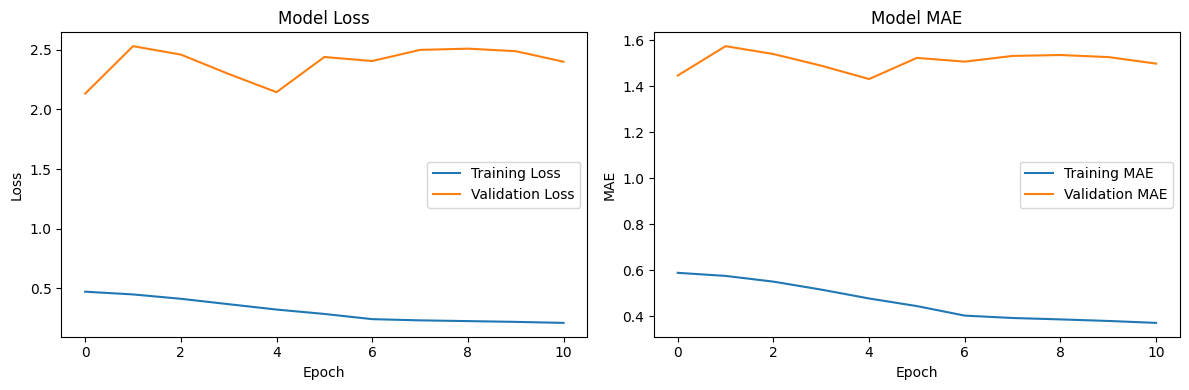

In [11]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
